In [ ]:
# default_exp cci

# Storm detection

> finds low pressure systems

In [ ]:
#export
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#export
from drcstools.derivative import *
from drcstools.storm import *

def stormdetection(stormobj, slpname = "slp", pmax = 100000):
    
    stormobj.derivative(slpname, N = 20, dim = stormobj._get_name_longitude(), order = 1)
    stormobj.derivative(slpname, N = 20, dim = stormobj._get_name_latitude(), order = 1)
    
    stormobj.derivative(slpname, N = 20, dim = stormobj._get_name_longitude(), order = 2)
    stormobj.derivative(slpname, N = 20, dim = stormobj._get_name_latitude(), order = 2)    
        
    zero_crossings_x = xr.where(xr.ufuncs.signbit(stormobj.ds["dd{}{}".format(stormobj._get_name_longitude(),
                                                                                slpname)]).astype(int).diff("lon") != 0, 1, 0)
    zero_crossings_y = xr.where(xr.ufuncs.signbit(stormobj.ds["dd{}{}".format(stormobj._get_name_latitude(),
                                                                                slpname)]).astype(int).diff("lat") != 0, 1, 0)
    zero_crossings = xr.where((zero_crossings_x == 1) & (zero_crossings_y == 1), 1, 0)
    
    dP = 0.5 * (stormobj.ds["dd{}{}".format(stormobj._get_name_longitude(), slpname)] + stormobj.ds["dd{}{}".format(stormobj._get_name_latitude(), slpname)])
    
    Pzonal = dP.mean([stormobj._get_name_time(), stormobj._get_name_latitude()])

    lows = stormobj.ds[slpname].where(zero_crossings == 1).where(dP - Pzonal < 0)
    dP = dP.where(lows < pmax)
    lows = lows.where(lows < pmax)
    
    stormobj.ds["lows"] = lows
    stormobj.ds["dP"] = dP
    return stormobj


# def stormtracking(storm)

# Examples

In [ ]:
# ds = xr.open_dataset("data/rca_unrot_data_1_5.nc", use_cftime = True)
# ds = ds.rename({"rlon":"lon", "rlat":"lat"})

In [ ]:
ds = xr.open_dataset("data/era5.nc", use_cftime = True).isel(time = slice(0,2))

In [ ]:
stormtrack = storm(ds = ds)
stormtrack.set_up(force = True)

INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'



In [ ]:
stormtrack = stormdetection(stormtrack, slpname = "msl")

  0%|          | 0/2 [00:00<?, ?it/s]

Calculating d/dlon for all time, lat points ...


  0%|          | 0/2 [00:00<?, ?it/s]

Calculating d/dlat for all time, lon points ...


  0%|          | 0/2 [00:00<?, ?it/s]

Calculating d/dlon for all time, lat points ...


  0%|          | 0/2 [00:00<?, ?it/s]

Calculating d/dlat for all time, lon points ...


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


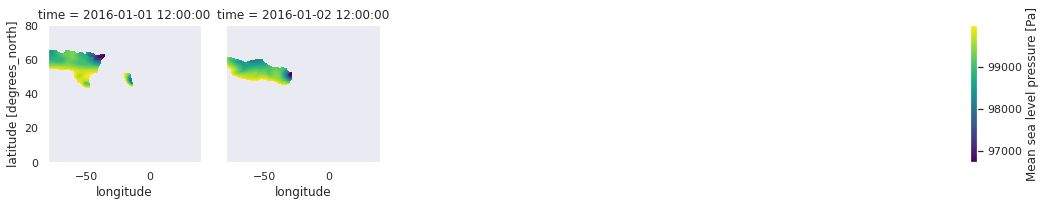

In [ ]:
stormtrack.ds.lows.plot(col = "time", col_wrap = 5)

In [ ]:
da_stacked = stormtrack.ds.lows.isel(time = 0).stack(x=['latitude','longitude']) 
da_stacked[da_stacked.notnull()]

<xarray.DataArray 'lows' (x: 8685)>
array([99997.414, 99991.74 , 99987.2  , ..., 98513.4  , 98531.336,
       99224.76 ], dtype=float32)
Coordinates:
    time       object 2016-01-01 12:00:00
  * x          (x) MultiIndex
  - latitude   (x) float64 43.5 43.5 43.5 43.5 43.5 ... 65.25 65.25 65.25 65.25
  - longitude  (x) float64 -49.0 -48.75 -48.5 -48.25 ... -76.5 -76.25 -65.25
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_mean_sea_level

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = stormtrack.ds.msl.sel(longitude = -50, method = "nearest").isel(time = 1)
ddata = stormtrack.ds.ddlatitudemsl.sel(longitude = -50, method = "nearest").isel(time = 1)
d2data = stormtrack.ds.d2dlatitudemsl.sel(longitude = -50, method = "nearest").isel(time = 1)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

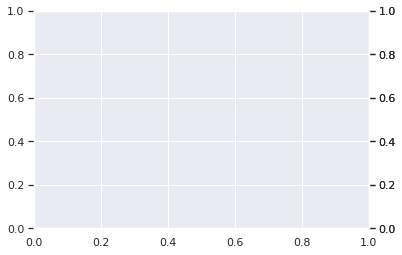

In [ ]:
sns.set()

f, ax = plt.subplots(1)

axes = [ax, ax.twinx(), ax.twinx()]
colors = sns.color_palette("hls", 8)


data.plot(ax = axes[0], color = colors[0])
ddata.plot(ax = axes[1], color = colors[1], ls="--")
d2data.plot(ax = axes[2], color = colors[2], ls="-.")
f.subplots_adjust(right=0.75)
axes[-1].spines['right'].set_position(('axes', 1.2))
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

for ax, color in zip(axes, colors):
    ax.tick_params(axis='y', colors=color)
    ax.grid(False)
axes[0].set_xlabel("Latitude")
axes[0].grid()